# Langevin dynamics simulation of a polymer confined between walls

## Overview


### Questions

- How do I perform a simulation of a polymer confined between walls?

### Objectives


- Compute the density profile of the polymer between the walls

## Workflow

### Import packgages
Let's import the packages needed for the job.

In [1]:
import gsd.hoomd
import hoomd
import matplotlib
import numpy as np
import os

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

### Building the polymer
For this tutorial, we will use a single polymer chain. Let's build a linear polymer with $N$ monomers in a cubic box of length, $L$. The polymer is oriented along the $x-\text{axis}$ and centered in the box. The output is saved in a GSD file, `polymer.gsd`.

We should make sure the file does not already exist in our directory.

In [2]:
file = os.path.join(os.getcwd(), "polymer.gsd")
if os.path.exists(file):
    os.remove(file)

In [3]:
L = 100
N = 30
bond = 1.0
positions = np.zeros((N, 3), dtype=float)
for i in range(N):
    positions[i, 0] = i * bond - ((N - 1) * 0.5)

frame = gsd.hoomd.Frame()
frame.configuration.box = [L, L, L, 0, 0, 0]

# beads
frame.particles.N = N
frame.particles.position = positions
frame.particles.typeid = np.zeros(frame.particles.N, dtype=int)
frame.particles.types  = ["A"]
frame.particles.mass   = np.full(frame.particles.N, 1.0) 

# bonds
frame.bonds.N = N - 1
frame.bonds.typeid = np.zeros(frame.bonds.N, dtype=int)
frame.bonds.types = ["A"]
frame.bonds.group = np.column_stack((range(0, N - 1), range(1, N)))

with gsd.hoomd.open("polymer.gsd", "w") as f:
    f.append(frame)

### Running the simulation

The initial simulation state will be [created](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/simulation.html#hoomd.Simulation.create_state_from_gsd)
from the `GSD` file containing the polymer we just built.

In [4]:
dev = hoomd.device.CPU()
simulation = hoomd.Simulation(device=dev, seed=2)
simulation.create_state_from_gsd("polymer.gsd")

We will define the integrator. An integration step size of $\Delta t = 0.005$ will be used.

In [5]:
integrator = hoomd.md.Integrator(dt=0.005)
simulation.operations.integrator = integrator

Now, define the [Langevin method](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/methods/langevin.html).
You may use $kT=1.0$.

Remember to append it to the methods in the integrator.

In [6]:
ld = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0, default_gamma=0.1)
integrator.methods.append(ld)

Next up, we can now define the bonded and non-bonded interactions. We will use the Finite Extensible Nonelastic (FENE) potential, with Kremer-Grest parameters for our polymer.

$$
U_{\text{FENE}}(r) = -\dfrac{1}{2} k r_0^2 \ln \left[ 1 - \left( \dfrac{r}{r_0} \right)^2 \right]
$$

where:
- $r$ is the distance between the bonded particles,
- $k$ is the strength of the attractive force,
- $r_0$ is the maximum bond extension (beyond which the force becomes infinite and breaks).

A Weeks-Chandler-Andersen (WCA) potential is also incorporated to model the repulsive interactions.

$$
U_{\text{WCA}}(r) =
\begin{cases}
4\varepsilon \left[ \left( \dfrac{\sigma}{r} \right)^{12} - \left( \dfrac{\sigma}{r} \right)^6 \right] + \varepsilon, & r \leq 2^{1/6} \sigma \\
0, & r > 2^{1/6} \sigma
\end{cases}
$$

where:
- $\varepsilon$ is the repulsive interaction energy,
- $\sigma$ is the repulsive interactive width.

We must append these forces to the operations list through the integrator.

HOOMD-Blue uses [FENEWCA](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/bond/fenewca.html) to model these bonded interactions.

In [7]:
# bonded interactions
fenewca = hoomd.md.bond.FENEWCA()
fenewca.params["A"] = dict(k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)
integrator.forces.append(fenewca)

# non-bonded interactions
nl = hoomd.md.nlist.Tree(buffer=1.0, exclusions=["bond"])
wca = hoomd.md.pair.LJ(nlist=nl, default_r_cut=2.0 ** (1.0 / 6.0), mode="shift")
wca.params[("A", "A")] = dict(sigma=1.0, epsilon=1.0)
integrator.forces.append(wca)

We should also define the [polymer-wall interactions](https://hoomd-blue.readthedocs.io/en/stable/hoomd/wall/plane.html). The **radius of gyration**, $R_g$, of a 30-mer is approximately 3.4. Walls will be separated at $n \times R_g$, in the $y$-direction, where $n$ is a positive real number.

The two walls will be located at $y=-0.5\times$ WallSeparation and $y=0.5\times$ WallSeparation.

In [8]:
n = 1.5
wall_sep = n * 3.4

# set the wall locations in the y-direction
top_wall = hoomd.wall.Plane(origin=(0, 0.5*wall_sep, 0), normal=(0, -1, 0))
bottom_wall = hoomd.wall.Plane(origin=(0, -0.5*wall_sep, 0), normal=(0, 1, 0))

# define the interactions
wall_wca = hoomd.md.external.wall.LJ(walls=[top_wall, bottom_wall])
wall_wca = hoomd.md.external.wall.LJ(walls=[top_wall, bottom_wall])
wall_wca.params[("A")] = dict(sigma=1.0, epsilon=1.0, r_cut=2.0 ** (1.0 / 6.0))

integrator.forces.append(wall_wca)

We will define a gsd writer operation to periodically save trajectories to file.

In [9]:
gs = hoomd.write.GSD(
    trigger=1_000,
    filename="production.gsd",
    mode="wb",
    dynamic=['configuration/box','particles/N','particles/position','particles/image','particles/velocity']
)
simulation.operations.writers.append(gs)

We will now produce the simulation data for analyses.

In [10]:
simulation.run(30_000_000, write_at_start=True)
gs.flush()

### Analyzing the results

We will analyze the monomer and center-of-mass (COM) distributions of the polymer between the two walls.

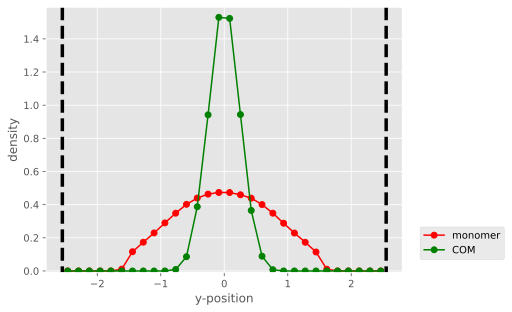

In [11]:
fig, ax = matplotlib.pyplot.subplots(1, 1)

nbins = 30
bin_edges = np.linspace(-0.5 * wall_sep, 0.5 * wall_sep, nbins+1)
mon_pos = []
com_pos = []
with gsd.hoomd.open("production.gsd", "r") as traj:
    for _, frame in enumerate(traj):
        pos = frame.particles.position + frame.configuration.box[:3] * frame.particles.image # unwrap coords
        mon_pos.extend(pos[:, 1])
        com_pos.append(np.mean(pos[:, 1], axis=0))

mon_pos = np.array(mon_pos)
mon_hist, _ = np.histogram(mon_pos, bin_edges, density=True)
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), mon_hist, marker="o", color="r", label="monomer")

com_pos = np.array(com_pos)
com_hist, _ = np.histogram(com_pos, bin_edges, density=True)
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), com_hist, marker="o", color="g", label="COM")

wall = np.linspace(-0.05, 1.06 * np.max(com_hist), 10)
ax.plot(np.full_like(wall, -0.5 * wall_sep), wall, "k--", lw=3.5)
ax.plot(np.full_like(wall, 0.5 * wall_sep), wall, "k--", lw=3.5)
ax.set_ylim([-0.01, 1.04 * np.max(com_hist)])

ax.legend(loc=(1.05, 0.05))
ax.set_xlabel("y-position")
ax.set_ylabel("density")

matplotlib.pyplot.show()